In [1]:
# Conclusion: Subjects have lots of response variables (age, sex, intelligence), which KCCA can't
# disentangle very well... not the case for simulations

# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['nback'])
print(len(subs))

X = get_X(allts, ['nback'], subs)
print(X[0].shape)

905
(905, 264, 231)


In [4]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [ts_to_flat_fc(ts) for ts in filter_design_ts(X[0])]
p = np.stack(p)
print(p.shape)

(905, 34716)


In [9]:
y = get_y(metadict, ['age'], subs)[0]
ytr = y[:600]
yt = y[600:]

trgrp1 = np.where(ytr < 14*12)[0][0:200]
trgrp2 = np.where(ytr >= 14*12)[0][0:200]

In [13]:
from cca_zoo.models import rCCA, KTCCA

cca = KTCCA(latent_dims=1)
cca.fit((p[trgrp1], p[trgrp2]))
load = cca.get_loadings((p[trgrp1], p[trgrp2]))

print(load[0].shape)
print(load[1].shape)

(34716, 1)
(34716, 1)


In [20]:
a,b = np.triu_indices(264, 1)
idcs0 = np.argsort(np.abs(load[1][:,0]))
for idx in idcs0[-5:]:
    print((idx,a[idx],b[idx]))
idcs1 = np.argsort(np.abs(load[1][:,0]))
for idx in idcs1[-5:]:
    print((idx,a[idx],b[idx]))

(3966, 15, 142)
(33633, 216, 262)
(33586, 215, 262)
(4022, 15, 198)
(18903, 85, 204)
(3966, 15, 142)
(33633, 216, 262)
(33586, 215, 262)
(4022, 15, 198)
(18903, 85, 204)


In [26]:
import torch
import torch.nn as nn

mseLoss = nn.MSELoss()

xtr = torch.from_numpy(p[:600]).float().cuda()
xt = torch.from_numpy(p[600:]).float().cuda()

ytr_t = torch.from_numpy(ytr).float().cuda()
yt_t = torch.from_numpy(yt).float().cuda()

w, _, _, _ = torch.linalg.lstsq(xtr, ytr_t)

print(mseLoss(xtr@w, ytr_t)**0.5)
print(mseLoss(xt@w, yt_t)**0.5)

tensor(0.0002, device='cuda:0')
tensor(29.3293, device='cuda:0')


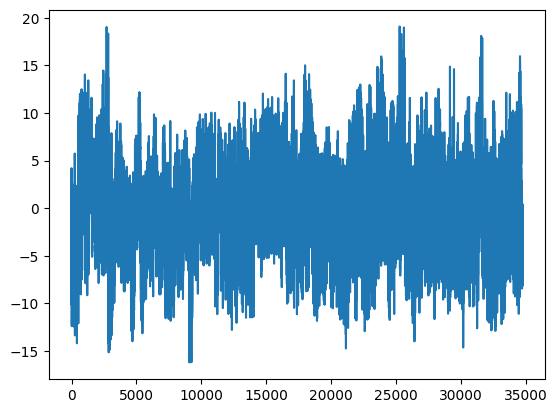

In [14]:
import matplotlib.pyplot as plt

plt.plot(load[0][:,0])
plt.show()